<a href="https://colab.research.google.com/github/nehakinjal/ML-Portfolio/blob/main/Malaria_Detection/Final_Reference_Notebook_Malaria_Detection_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>

* Malaria is a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes. The parasites enter the blood and begin damaging red blood cells (RBCs) that carry oxygen, which can result in respiratory distress and other complications.
* Almost 50% of the world’s population is in danger from malaria. There were more than 229 million malaria cases and 400,000 malaria-related deaths reported over the world in 2019.
* Children under 5 years of age are the most vulnerable population group affected by malaria; in 2019 they accounted for 67% of all malaria deaths worldwide.
* The lethal parasites can stay alive for more than a year in a person’s body without showing any symptoms. Therefore, late treatment can cause complications and could even be fatal.
* Traditional diagnosis of malaria in the laboratory is a tedious, time-consuming process, and the diagnostic accuracy (which heavily depends on human expertise) can be adversely impacted by inter-observer variability and hence can be highly inconsistent.


**The objectives:** What is the intended goal?<br>
* Build an automated system that can help with the early and accurate detection of malaria by analyzing the images of red blood cells.


**The key questions:** What are the key questions that need to be answered?<br>
* Can we design a Machine learning and Artificial intelligence model to classify Red blood cell images into ‘parasitized’ and ‘uninfected’ groups with high accuracy and consistency?
* Can Deep learning classification methods attain an accuracy comparable with  human diagnostic methods?


**The problem formulation:** What is it that we are trying to solve using data science?
* Build an efficient computer vision model to detect malaria. The model should identify whether the image of a red blood cell is that of one infected with malaria or not, and classify the same as parasitized or uninfected, respectively.
* This is a binary classification problem with focus on detecting the ‘parasitized’ RBC cells as accurately as possible with minimum false negatives. Labeling ‘parasitized’ cells as uninfected can result in fatal outcomes due to severity of this disease.The measure of recall is going to be very important for the ‘parasitized’ class here.


## <b>Data Description </b>

This dataset consists of colored microscopic images of red blood cells that contain parasitized and uninfected instances, where:
* The parasitized cells contain the Plasmodium parasite
* The uninfected cells are free of the Plasmodium parasites but could contain other impurities.


###<b> Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <b>Loading libraries</b>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow crashes on Google colab, using patch provided by Google

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, LeakyReLU, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

#<b>Data Loading

####<b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Data Science/MIT-DS/code/Capstone Project/Deep Learning/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
data_folder = '/content/cell_images/'
picture_size = 32 #64

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

#<b>Data Exploration</b>


###<b> Check the shape of train and test images

In [ ]:
# Here we will be using a user defined function load_data() to extract the images from the directory

# Load images
def load_data(datatype):
  '''
  Loads data from drive.
  input - datatype 'train' or 'test'
  returns rbc_state categorized data, features and labels
  '''

  features_and_labels = []

  rbc_state_data = {'parasitized':[], 'uninfected':[]}
  for rbc_state in rbc_state_data.keys():                                         # Looping over each category from the rbc_categories list
      path = os.path.join(data_folder + datatype + '/', rbc_state)                # Joining images with labels

      X = []
      for img in os.listdir(path):
          img_array = cv2.imread(os.path.join(path, img))                        # Reading the data
          new_array = np.array(cv2.resize(img_array, (picture_size, picture_size))) # Resizing the images

          X.append(new_array)
          features_and_labels.append([new_array, rbc_state])                     # Appending both the images and labels

      # Add to rbc state categorized data dictionary
      rbc_state_data[rbc_state] = np.array(X)

  return (rbc_state_data, features_and_labels)


rbc_state_data_train, features_and_labels_train = load_data('train')
rbc_state_data_test, features_and_labels_test = load_data('test')


**Note**

* As data was seggregated per class when we read from file system we must shuffle the data for different classes before training and validating any model.

In [ ]:
# User defined function to shuffle and create arrays for features X and target values y

def shuffled_features_labels(features_and_labels):

  X = []
  y = []

  np.random.shuffle(features_and_labels)

  for features, label in features_and_labels:                                          # Iterating over the training data which is generated from the create_training_data() function
    X.append(features)                                                   # Appending images into X_train
    y.append(label)

  return (np.array(X), np.array(y))

X_train, y_train = shuffled_features_labels(features_and_labels_train)
X_test, y_test = shuffled_features_labels(features_and_labels_test)


###<b> Check the shape of train and test labels

In [ ]:
print('Shape of train dataset,', X_train.shape, 'target set', y_train.shape)
print('Shape of test dataset,', X_test.shape, 'target set', y_test.shape)

Shape of train dataset, (24958, 32, 32, 3) target set (24958,)
Shape of test dataset, (2600, 32, 32, 3) target set (2600,)


####<b> Observations and insights:
* There are 24958 feature images in training data
* There are 2600 feature images in test data
* Images are of different sizes
* As the data for each class of images is segregated in different folders it’s important to shuffle the images with it’s target value for better model training efficiency.




### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
# Function to print pixel value range for each color R,G,B
def print_pixel_val_range(dataset):
  print('Min ',[np.amin(dataset[:,:,:,0]), np.amin(dataset[:,:,:,1]), np.amin(dataset[:,:,:,2])])
  print('Max ',[np.amax(dataset[:,:,:,0]), np.amax(dataset[:,:,:,1]), np.amax(dataset[:,:,:,2])])

print("Training set range...")
print_pixel_val_range(X_train)

print("Test set range...")
print_pixel_val_range(X_test)

Training set range...
Min  [0, 0, 0]
Max  [237, 235, 255]
Test set range...
Min  [0, 0, 0]
Max  [208, 219, 255]


####<b> Observations and insights:

* Images are in RGB color space with pixel value range 0-255
* Given that this is an image processing/detection problem we plan to use deep learning techniques using convolutional neural network model.
* Images are of different sizes, to analyze, and CNN models require the images to be of the same size. While reading the dataset into arrays we made sure to resize the images to a uniform picture size and aspect ratio, in this case 32x32.
* We would like to normalize the pixel value from the range or 0-255 to 0-1. This makes convergence faster while training the neural network.






###<b> Count the number of values in both uninfected and parasitized

In [ ]:
print('Train dataset \n',pd.DataFrame(y_train).value_counts())
print('Test dataset \n',pd.DataFrame(y_test).value_counts())


Train dataset 
 parasitized    12582
uninfected     12376
dtype: int64
Test dataset 
 parasitized    1300
uninfected     1300
dtype: int64


###<b>Normalize the images

In [ ]:
X_train = X_train/255

print("Training set range...")
print_pixel_val_range(X_train)


Training set range...
Min  [0.0, 0.0, 0.0]
Max  [0.9294117647058824, 0.9215686274509803, 1.0]


In [ ]:
X_test = X_test/255

print("Test set range...")
print_pixel_val_range(X_test)


Test set range...
Min  [0.0, 0.0, 0.0]
Max  [0.8156862745098039, 0.8588235294117647, 1.0]


####**Observations and insights:**

* Both training and test dataset is almost equally divided into ‘parasitized’ and ‘uninfected’ images. So the dataset is pretty balanced for binary classification.
* RGB pixel value range for training dataset is a little larger than that of test dataset. This might be due to size of dataset and larger range of colors in train dataset.

###<b> Plot to check if the data is balanced

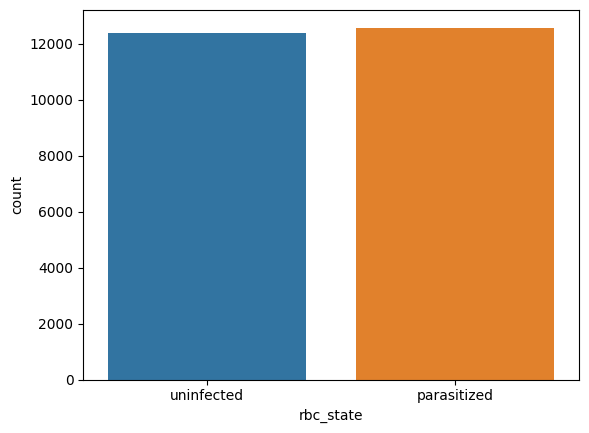

In [ ]:
# Plot distribution of each category
df = pd.DataFrame({'rbc_state': y_train})
df.head()
count_plot = sns.countplot(data=df, x='rbc_state')


####**Observations and insights:**

* Both training and test dataset is almost equally divided into ‘parasitized’ and ‘uninfected’ images. So the dataset is pretty balanced for binary classification.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

In [ ]:
# Function to visualize images from image array
def show_images(image_array, labels=np.array([]), hsv=False, limit=30):
  '''
  Show images from the array
  '''

  if len(image_array) < limit:
    print('<image_array> has less images than specified <count>')
    limit = len(image_array)

  plt.figure(figsize = (12, 12))

  i=1
  for img in image_array[:limit]:
      #plot image
      if hsv == False:
        plt.subplot(6, 6, i)
        plt.imshow(img)
        # Create space for labels, anyway xticks do not carry much value
        plt.xticks(ticks=[])

        #print label if it exists
        if (len(labels) >= i):
          plt.title(labels[i-1])
      else:
        cv2_imshow(img) # supports RGB and HSV format

      i += 1

  plt.show()



Show first few training images



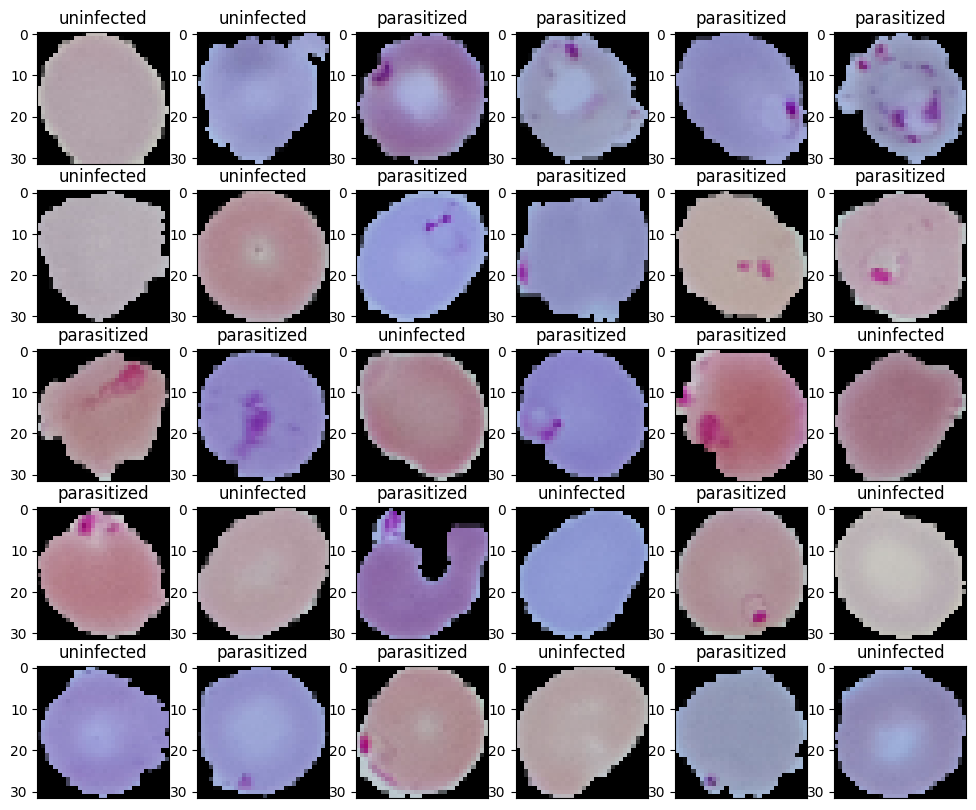

In [ ]:
# Show first few training images
print('Show first few training images\n')
show_images(X_train, y_train)




Show first few test images



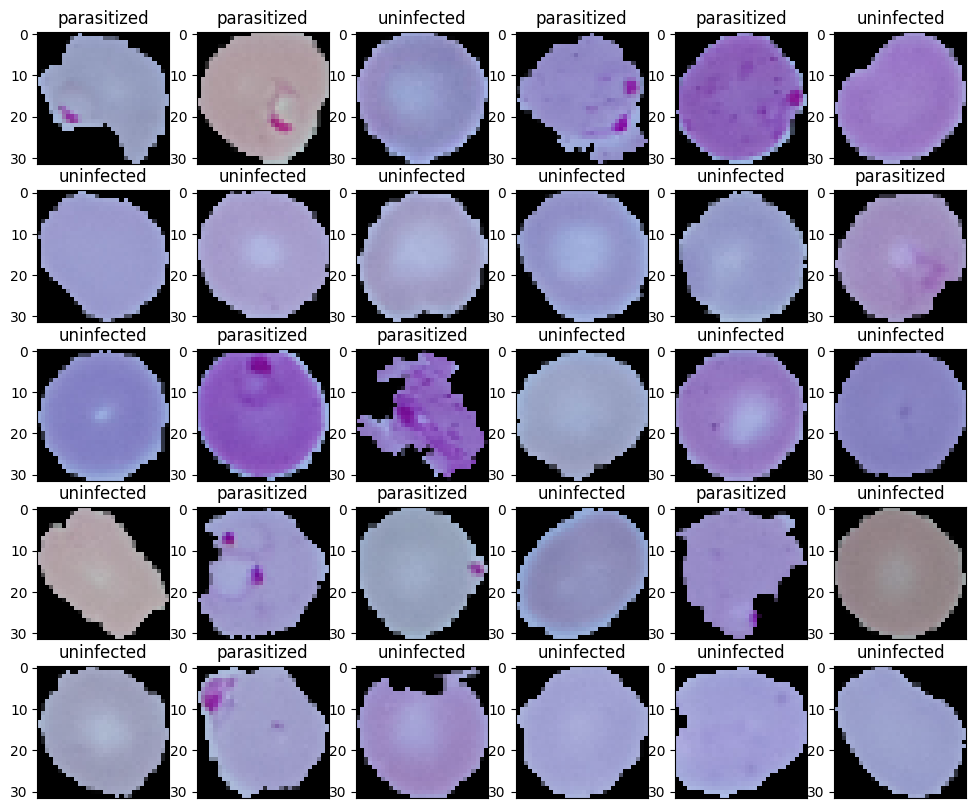

In [ ]:
# Show first few test images
print('Show first few test images\n')
show_images(X_test, y_test)


Show only 'parasitized' images



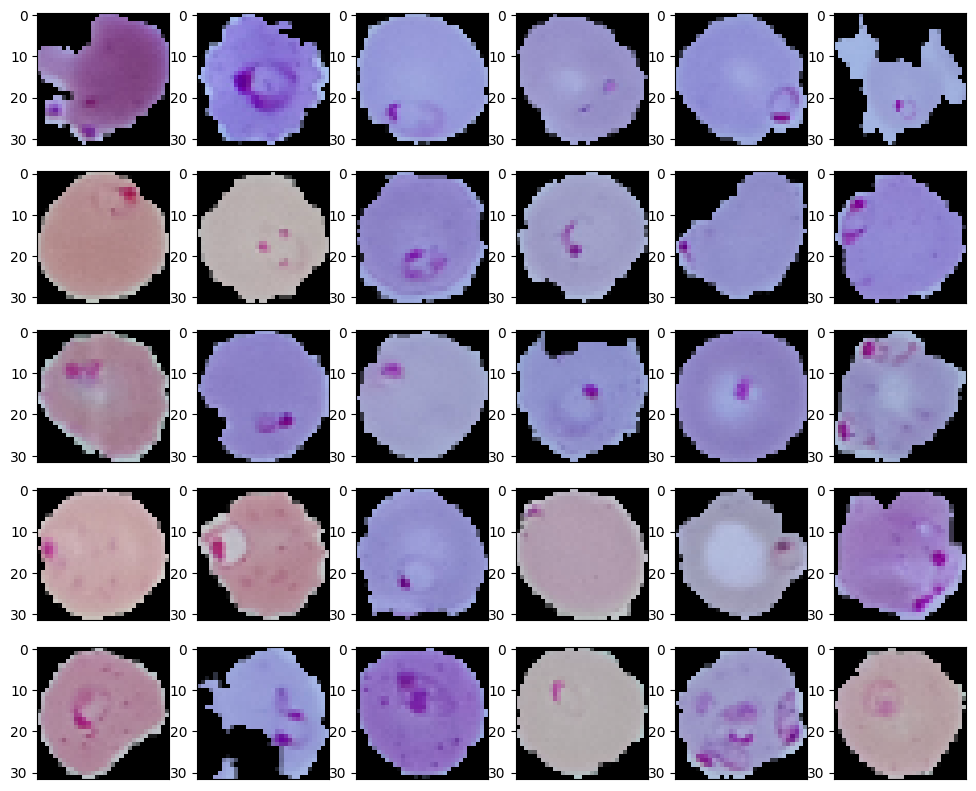

In [ ]:
# Show 'parasitized' RBCs
print("Show only 'parasitized' images\n")
show_images(rbc_state_data_train['parasitized'])

Show only 'uninfected' images



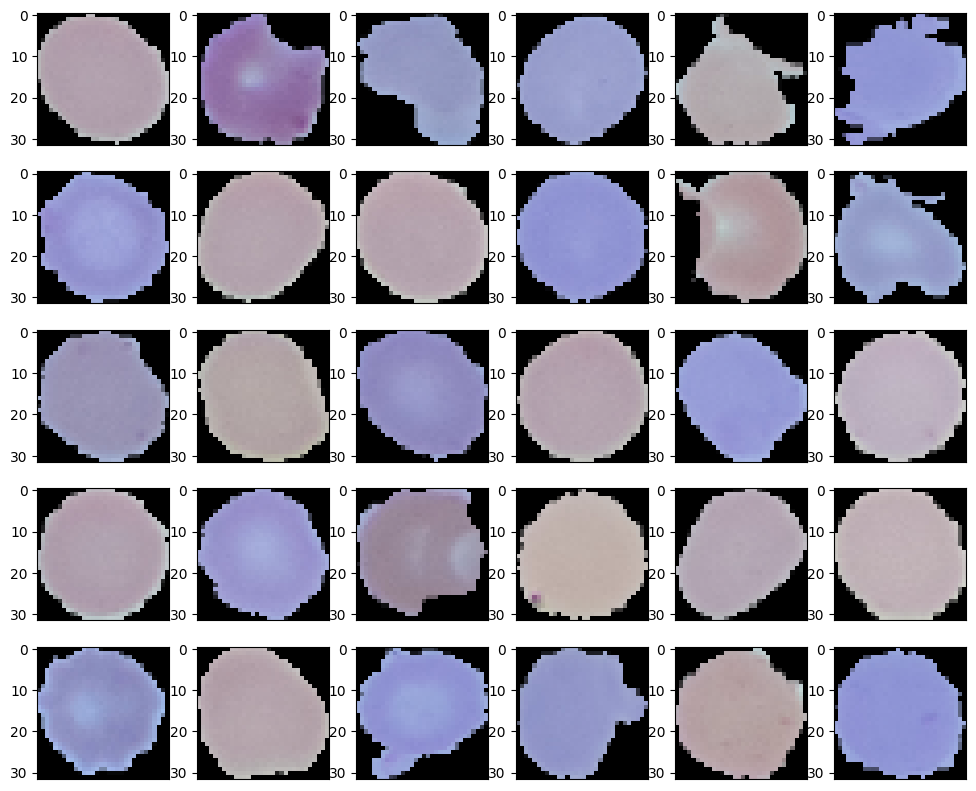

In [ ]:
# Show 'uninfected' RBCs
print("Show only 'uninfected' images\n")
show_images(rbc_state_data_train['uninfected'])

####**Observations and insights:**

* Visualization shows that parasitized RBC images have darker color pigmentation in the cell. Whereas the uninfected RBC cells have more uniform color.
* Also parasitized and uninfected cells are mostly circular in shape but some can have uneven outer shape.
* Overall color of the RBC cell can range from shades of pink to purple to blue for both classes of images.


####<b> Plotting the mean images for parasitized and uninfected

In [ ]:
#Normalize data
rbc_state_data_train['parasitized'] = rbc_state_data_train['parasitized']/255
rbc_state_data_train['uninfected'] = rbc_state_data_train['uninfected']/255

In [ ]:
# Function to show mean image
def showMeanImage(img_array):
  '''
  show mean image from the array of images
  img_array - 4D array with RGB images
  '''
  # Find mean for each pixel in the image
  img = np.mean(img_array[:, :, :, 0:3], axis=0)

  # Show the image
  plt.imshow(img)
  plt.show()





<b> Mean image for parasitized

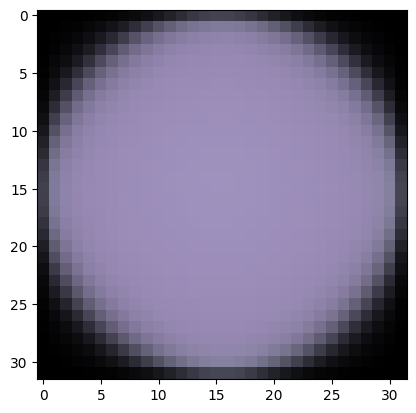

In [ ]:
showMeanImage(rbc_state_data_train['parasitized'])


<b> Mean image for uninfected

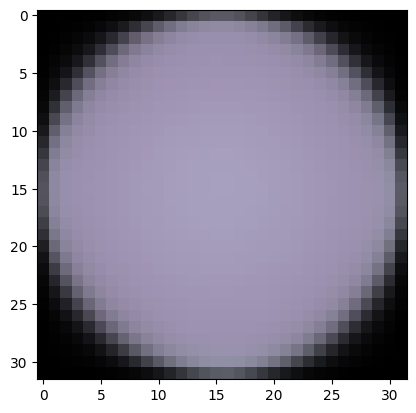

In [ ]:
showMeanImage(rbc_state_data_train['uninfected'])


####**Observations and insights:**
* When looking at mean images for the 2 classes of RBC images we notice that parasitized images have slightly darker purple color. Which is in line with our observation that parasitized cells have darker color pigmentation in the cells.

#**Data Pre-processing steps:**

* Images must be square in shape and must be decreased in size to improve efficiency of the model. Reducing the size to 32x32 pixels here
HSV color space corresponds better to how people experience color than the RGB color space does.
* As we are using neural networks it might be better to use HSV color space.
To reduce any noise in the images we can apply
* Gaussian blurring technique. This will definitely help in reducing the overfit to the model.


### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

Show HSV training images


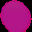

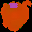

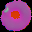

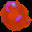

<Figure size 1200x1200 with 0 Axes>

(24958, 32, 32, 3)

In [ ]:
# Function to traverse the image array and apply conversion methods to images
def apply_conversion(converter, X):
  '''
  Function to apply conversion lambda to each image
  X - image list, 4D array
  converter - lambda tha ttakes image as input and applies some conversion and returns an image
  '''

  X_converted = np.array([converter(xi) for xi in X])

  return X_converted

#Convert RGB values back to 0-255 range for successful conversion to HSV
rgb_to_hsv_converter = lambda image : np.array(cv2.cvtColor(np.uint8(image*255), cv2.COLOR_BGR2HSV))

#Convert training images to HSV format
X_train_hsv = apply_conversion(rgb_to_hsv_converter, X_train)

print("Show HSV training images")
show_images(X_train_hsv, y_train, hsv=True, limit=4)
X_train_hsv.shape

###<b> Converting the test data

Show HSV test images


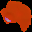

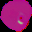

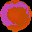

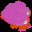

<Figure size 1200x1200 with 0 Axes>

(2600, 32, 32, 3)

In [ ]:
#Convert test images to HSV format
X_test_hsv = apply_conversion(rgb_to_hsv_converter, X_test)

print("Show HSV test images")
show_images(X_test_hsv, y_test, hsv=True, limit=4)
X_test_hsv.shape

####<b>Observations and insights: _____

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

Show Gaussian Blur training images


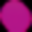

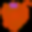

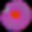

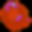

<Figure size 1200x1200 with 0 Axes>

(24958, 32, 32, 3)

In [ ]:
# Gaussian Blur with kernel size 7x7
gaussian_blur_converter = lambda image : cv2.GaussianBlur(image, (7,7), 0)

#apply Gaussian Blur to training images
X_train_hsv_gaussian = apply_conversion(gaussian_blur_converter, X_train_hsv)

print("Show Gaussian Blur training images")
show_images(X_train_hsv_gaussian, y_train, hsv=True, limit=4)
X_train_hsv_gaussian.shape

###<b> Gaussian Blurring on test data

Show Gaussian Blur test images


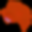

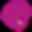

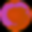

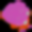

<Figure size 1200x1200 with 0 Axes>

(2600, 32, 32, 3)

In [ ]:
#apply Gaussian Blur to test images
X_test_hsv_gaussian = apply_conversion(gaussian_blur_converter, X_test_hsv)

print("Show Gaussian Blur test images")
show_images(X_test_hsv_gaussian, y_test, hsv=True, limit=4)
X_test_hsv_gaussian.shape

####**Observations and insights: _____**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

* Gaussian Blur is used typically to reduce image noise and reduce detail.
* Other image blurring options are Median Blur or Bilateral blur
* Median Blur removes salt and pepper kind of noise
* Bilateral Blur is edge-preserving, and noise-reducing smoothing filter. It preserves sharp edges while discarding the weak ones.

As these images do not have much Salt & pepper noise we will skip Median Blur technique. But Bilateral blur might be a good option to try.

###<b> Bilateral blurring on train data

Show bilateral blur training images


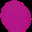

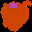

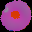

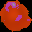

<Figure size 1200x1200 with 0 Axes>

(24958, 32, 32, 3)

In [ ]:
# Bilateral Blur with kernel size 7x7
bilateral_blur_converter = lambda image : cv2.bilateralFilter(image, 9, 75, 75)

#apply Bilateral Blur to training images
X_train_hsv_bilateral = apply_conversion(bilateral_blur_converter, X_train_hsv)

print("Show bilateral blur training images")
show_images(X_train_hsv_bilateral, y_train, hsv=True, limit=4)
X_train_hsv_bilateral.shape

###<b> Bilateral Blurring on test data

Show bilateral blur testing images


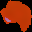

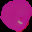

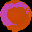

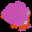

<Figure size 1200x1200 with 0 Axes>

(2600, 32, 32, 3)

In [ ]:
#apply Bilateral Blur to test images
X_test_hsv_bilateral = apply_conversion(bilateral_blur_converter, X_test_hsv)

print("Show bilateral blur testing images")
show_images(X_test_hsv_bilateral, y_test, hsv=True, limit=4)
X_test_hsv_bilateral.shape

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

####<B>One Hot Encoding the train and test labels

In [ ]:
# Convert target labels from names to one hot vectors.
from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()

y_train_encoded = enc.fit_transform(y_train)

y_test_encoded = enc.transform(y_test)

In [ ]:
enc.classes_

array(['parasitized', 'uninfected'], dtype='<U11')

In [ ]:
y_train_encoded.shape, y_test_encoded.shape

((24958, 1), (2600, 1))

###<b> Building the model

### Fix the seed for random number generators, clear backend

In [ ]:
from tensorflow.keras import backend # Clearing backend
import random # Fixing the seed for random number generators

# Function to clear older session and re-initialize the random number generators
def initialize_session():

  backend.clear_session()

  # Fixing the seed for random number generators so that we can ensure we receive the same output everytime
  np.random.seed(42)

  random.seed(42)

  tf.random.set_seed(42)

initialize_session()

In [ ]:
print("Gaussian Training set range...")
print_pixel_val_range(X_train_hsv_gaussian)

print("Bilateral Training set range...")
print_pixel_val_range(X_train_hsv_bilateral)

Gaussian Training set range...
Min  [0, 0, 0]
Max  [179, 232, 245]
Bilateral Training set range...
Min  [0, 0, 0]
Max  [179, 255, 248]


###<b>NOTE:

#### We tried using Bilateral blur applied dataset for model building as this blur preserves sharp edges and removes noise. But the model took a long time to train and it was greatly underfit. So switching to Gaussian blurring.

###<b>Normalize Data

In [ ]:
def get_normalized_features(train, test):


  # Divide by 255 to normalize the data as the range is 0-255
  train_normalized = train.astype('float32')/255.0
  print_pixel_val_range(train_normalized)

  test_normalized = test.astype('float32')/255.0
  print_pixel_val_range(test_normalized)

  return (train_normalized, test_normalized)


X_train_normalized, X_test_normalized = get_normalized_features(X_train_hsv_gaussian, X_test_hsv_gaussian)


Min  [0.0, 0.0, 0.0]
Max  [0.7019608, 0.9098039, 0.9607843]
Min  [0.0, 0.0, 0.0]
Max  [0.7019608, 0.87058824, 0.95686275]


###<b>Note:
#####Tried running the following cnn_model_0 with Bilaterally filtered data but it resulted with a lot of bias, training data was greatly underfit. Clearing some RAM here.

In [ ]:
#deleting bilaterally filterred data to clear up RAM
# del X_train_hsv_bilateral, X_test_hsv_bilateral

#<b>Model building

###**Attempt 1. cnn_model_0 with gaussian blurred data**

* Convolusion neural network with 2 hidden layers
  * Layer 1 - 128 neurons
  * Layer 2 - 64 neurons
* Maxpooling applied after each hidden layer for dimensionality reduction
* Fully connected dense layer with 8 neurons after flattening the image vectors
* Using Relu activation after each layer
* Final output layer with single neuron, binary_crossentropy and sigmoid activation.
* Dropout layer added finally to drop 30% of neurons to reduce overfitting to training data.
* Training data pre-processing
  * HSV colorspace
  * Gaussian blurring applied to reduce noise from the image.

####<b>Creating and compiling models:

In [ ]:
def cnn_model_0():
  # Intializing a sequential model
  model = Sequential()

  # Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
  # Input_shape denotes input image dimension of images
  model.add(Conv2D(128, (3, 3), activation = 'relu', padding = "same", input_shape = (picture_size, picture_size, 3)))

  # Adding max pooling to reduce the size of output of first conv layer
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same"))
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  # flattening the output of the conv layer after max pooling to make it ready for creating dense connections
  model.add(Flatten())

  # Adding a fully connected dense layer with 100 neurons
  model.add(Dense(8, activation = 'relu'))
  model.add(Dropout(0.3))

  # Adding the output layer with 1 neurons and activation functions as sigmoid since this is a binary classification problem
  model.add(Dense(1, activation = 'sigmoid'))

  # Using SGD Optimizer
  # opt = SGD(learning_rate = 0.01, momentum = 0.9)
  opt=Adam(learning_rate=1e-3)

  # Compile model
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Generating the summary of the model
  model.summary()

  return model

<b> Using Callbacks

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0001)


<b> Fit and train our Model

In [ ]:
# Function to fit the model
def fit_model(model, X, y):

  history = ( model.fit(
              X, y,
              epochs = 10,
              validation_split = 0.1,
              shuffle = False,
              batch_size = 64,
              verbose = 1,
              callbacks = [learning_rate_reduction]
  ))
  return model, history

####<b> Evaluating the model on test data

<b> Plotting the confusion matrix

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Function to print classification report with accuracies and plot confusion matrix
def accuracy_reports(test, predicted):

  report = classification_report(test, predicted)
  print(report)

  cm = confusion_matrix(test, predicted)

  plt.figure(figsize = (8, 5))

  sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = enc.classes_, yticklabels = enc.classes_)

  plt.ylabel('Actual')

  plt.xlabel('Predicted')

  plt.show()
  return report


<b>Plotting the train and validation curves

In [ ]:
#function to plot model train and validation accuracy
def plot_accuracies(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
#Function to evaluate the model and print classification report and confusion matrix
def evaluate_model(model, history, X, y):

  accuracy = model.evaluate(X, y, verbose = 2)

  #Plot train and validation accuracy curves
  plot_accuracies(history)


  # Getting the output as probablities for each category, convert to boolean
  # Rounding uses .5 as thereshold, which is good for this example,
  # as the data is pretty balanced with equal 'parasitized' and 'uninfected' images
  y_pred = np.round(model.predict(X))

  #free up some RAM delete the models
  del model, history

  # Print classification report and confusion matrix
  return accuracy_reports(y, y_pred)

In [ ]:
#Clear the backend session in re-initialize the random number generators
initialize_session()

In [ ]:
# Train model
model, history = fit_model(cnn_model_0(), X_train_normalized, y_train_encoded)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 8)                 3

82/82 - 3s - loss: 0.6932 - accuracy: 0.5000 - 3s/epoch - 40ms/step


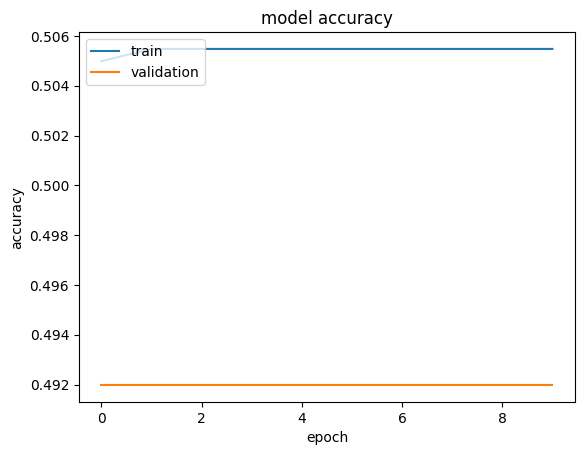

82/82 [==============================] - 6s 71ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1300
           1       0.00      0.00      0.00      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


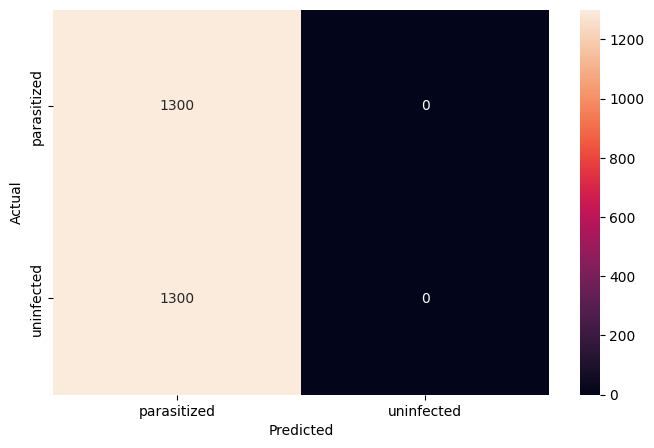

In [ ]:
# Print and Save all reports for each model here
accuracy_reports_dict = dict()
accuracy_reports_dict["cnn_model_0"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###<b>Think about it:</b><br>

Observations and insights:

* This model has a lot of bias and is underfits the training data. Validation data is showing good accuracy but that might be just a co-incidence.
* As mentioned earlier we want make evry effort to reduce false negatives for parsitized(0) class. Hence we need to loo at recall and F1 score.
* Even though recall for parsitized(0) class is 1.00 the recall for uninfected (1) class is 0.35 very low. With this model we might diagnose too many uninfected patents as parsitized. Test data shows 846 cases of uninfected patients out of 1300 diagnosed as parasitized.
* Hence we must build a better model.



So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###**Attempt 2. cnn_model_1 with gaussian blurred data**

Trying to improve the performance of our model by adding new layers.

* Convolusion neural network with 4 hidden layers
  * Layer 1 - 128 neurons
  * Layer 2 - 64 neurons
  * Layer 3 - 64 neurons
  * Layer 4 - 32 neurons
* Maxpooling applied after every other hidden layer for dimensionality reduction
* Fully connected dense layer with 64 neurons after flattening the image vectors
* Using Relu activation after each layer
* Final output layer with single neuron, binary_crossentropy and sigmoid activation.
* Training data pre-processing
  * HSV colorspace
  * Gaussian blurring applied to reduce noise from the image.
* Dropout layer added finally to drop 30% of neurons to reduce overfitting to training data.

####<b> Building & Compiling the Model

In [ ]:
def cnn_model_1():
  # Intializing a sequential model
  model = Sequential()

  # Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
  # Input_shape denotes input image dimension of images
  model.add(Conv2D(128, (3, 3), activation = 'relu', padding = "same", input_shape = (picture_size, picture_size, 3)))

  # Adding max pooling to reduce the size of output of first conv layer
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same"))
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same"))
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(Conv2D(32, (3, 3), activation = 'relu', padding = "same"))
  model.add(MaxPooling2D((2, 2), padding = 'same'))


  # flattening the output of the conv layer after max pooling to make it ready for creating dense connections
  model.add(Flatten())

  # Adding a fully connected dense layer with 64 neurons
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.3))

  # Adding the output layer with 1 neurons and activation functions as sigmoid since this is a binary classification problem
  model.add(Dense(1, activation = 'sigmoid'))

  opt=Adam(learning_rate=1e-3)

  # Compile model
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Generating the summary of the model
  model.summary()

  return model

####<b>  Fit & evaluate the model: (use callbacks)
* Plotting the confusion matrix
* Plotting the train and the validation curves


In [ ]:
#Clear the backend session in re-initialize the random number generators
initialize_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

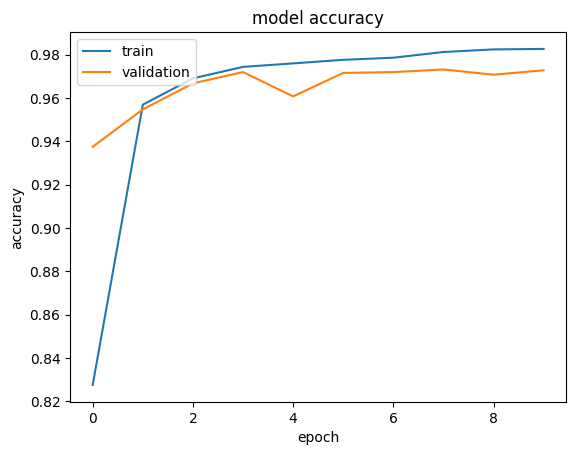

82/82 [==============================] - 5s 60ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



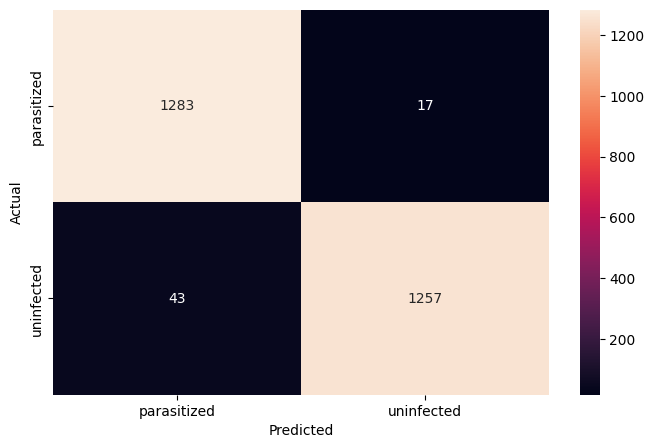

In [ ]:
# Train model
model, history = fit_model(cnn_model_1(),  X_train_normalized, y_train_encoded)

# Print and save reports for each model here
accuracy_reports_dict["cnn_model_1"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###<b>Think about it:</b><br>

**Observations and insights:**

* This model has very good performance on train and validation data
* Recall and F1-score for both classes is at 98% which is great.
* But there were 27 cases of false negatives, which means 27 infected patients were diagnosed as uninfected.
* Also, 32 uninfected patients were diagnosed as infected.
* We must explore if better options are available.


*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using **BatchNormalization** and using **LeakyRelu** as our activation function.

###<b> Attempt 3. cnn_model_2 with gaussian blurred data
(Using Batch Normalization and LeakyRelu activation)

####<b> Building & compiling the Model

In [ ]:
def cnn_model_2():
  # Intializing a sequential model
  model = Sequential()

  # Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
  # Input_shape denotes input image dimension of images
  model.add(Conv2D(128, (3, 3), padding = "same", input_shape = (picture_size, picture_size, 3)))
  model.add(LeakyReLU(0.1))
  # Adding max pooling to reduce the size of output of first conv layer
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(Conv2D(64, (3, 3), padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3), padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(Conv2D(32, (3, 3), padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D((2, 2), padding = 'same'))

  model.add(BatchNormalization())

  # flattening the output of the conv layer after max pooling to make it ready for creating dense connections
  model.add(Flatten())

  # Adding a fully connected dense layer with 64 neurons
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.3))

  # Adding the output layer with 1 neurons and activation functions as sigmoid since this is a binary classification problem
  model.add(Dense(1, activation = 'sigmoid'))

  opt=Adam(learning_rate=1e-3)

  # Compile model
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Generating the summary of the model
  model.summary()

  return model

####<b>  Fit & evaluate the model: (use callbacks)
* Plotting the confusion matrix
* Plotting the train and the validation curves


In [ ]:
#Clear the backend session in re-initialize the random number generators
initialize_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

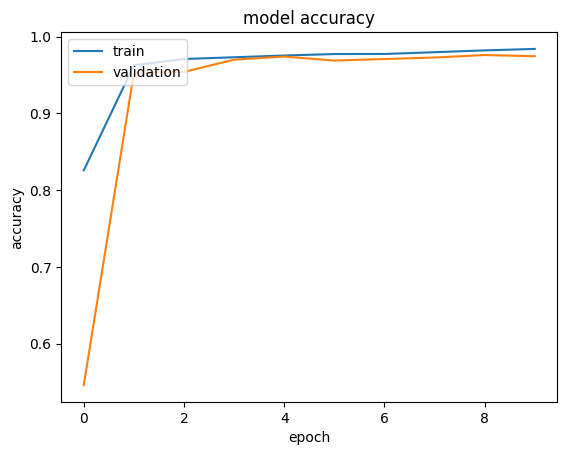

82/82 [==============================] - 6s 56ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



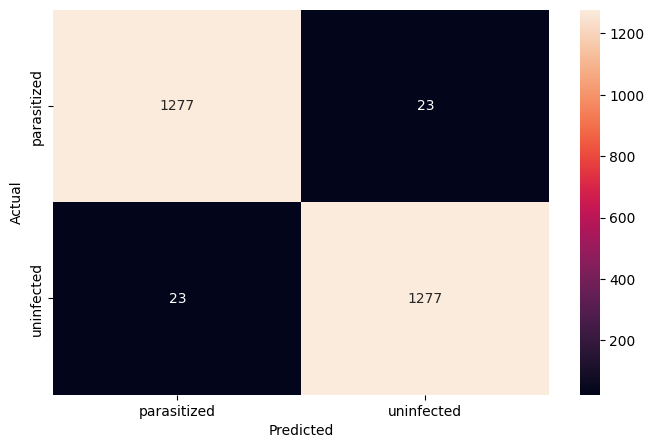

In [ ]:
# Train model
model, history = fit_model(cnn_model_2(), X_train_normalized, y_train_encoded)

# Print and save reports for each model here
accuracy_reports_dict["cnn_model_2"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>

Observations and insights:

* The performance of ths model is good but slighly inferior to earlier model.
* Parasitzed recall has improved at 98%, but recall for uninfected class is slightly lower 96%.
* 22 infected(parasitzed) patients were diagnosed as uninfected and 46 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* Also validation curve had a little dip showing slight instability of the model.







* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

###<b> Attempt 4. cnn_model_2 with gaussian blurred data and data Augmentation

####<b> Use image data generator

In [ ]:
def get_augmented_data(X, y):

  # Creating the data generator
  datagen = ImageDataGenerator(
                                rotation_range = 20,
                                fill_mode = 'nearest',
                                )
  # Batch size
  batch_size = X.shape[0]

  augmented = datagen.flow(X, y,
                                batch_size = batch_size,
                                shuffle = False)

  return augmented

In [ ]:
train_augmented = get_augmented_data(X_train_normalized, y_train_encoded, batch_size=64)

####<B>Visualizing Augmented images
* Let's visualize augmented versions of first 3 images.

<image_array> has less images than specified <count>


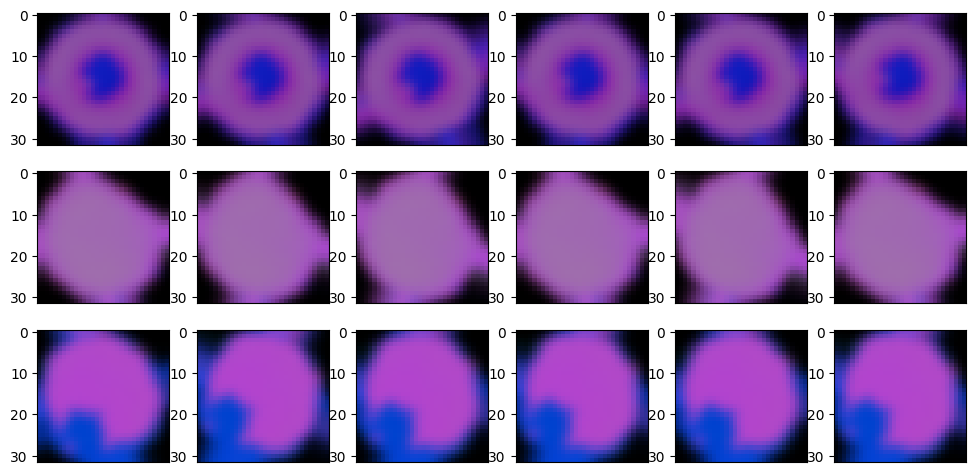

In [ ]:

train_augmented_sample = get_augmented_data(X_train_normalized[:3], y_train_encoded[:3])

train_augmented_sample_array = []
for  j in range(1, 4):

  for i in range(1,7):

    batch = train_augmented_sample.next()
    train_augmented_sample_array.append(batch[0][j-1])

show_images(train_augmented_sample_array)


####<b>Building the Model

In [ ]:
#Clear the backend session in re-initialize the random number generators
initialize_session()


In [ ]:
# Epochs
epochs = 10
model = cnn_model_2()

#Use the previous model to train with augmented data
history = model.fit(train_augmented,
                    epochs = epochs,
                    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                    validation_data = (X_test_normalized, y_test_encoded),
                    verbose = 1, callbacks = [learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

####<b>  Evaluate the model:
* Plotting the confusion matrix
* Plotting the train and the validation curves


82/82 - 5s - loss: 0.0666 - accuracy: 0.9777 - 5s/epoch - 64ms/step


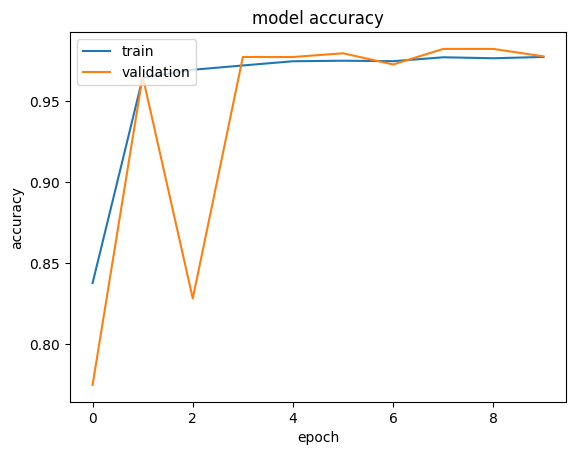

82/82 [==============================] - 6s 76ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1300
           1       0.97      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



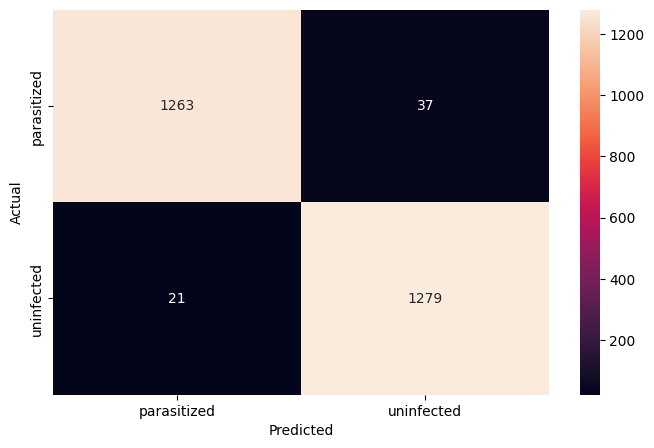

In [ ]:
# Print and save reports for each model here
accuracy_reports_dict["cnn_model_2_augmented"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>
**Observations and insights:**

* Parasitzed recall has improved at 99%, and recall for uninfected class has also improved at 97%.
* Only 14 infected(parasitzed) patients were diagnosed as uninfected and 34 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* So far this is the **best** model performance we have seen.

* We could check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator. But given the F1-score is very high at 98%, we will not explore further.



<b>Next Steps:

Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

###<b> Attempt 5. Pre-trained model (VGG16) with augmented data
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (picture_size, picture_size, 3))
vgg.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it

x = Flatten()(transfer_layer.output) # Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)


x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

pred = Dense(1, activation = 'sigmoid')(x)

model = Model(vgg.input, pred) # Initializing the model

####<b>Compiling the model

In [ ]:
# Compiling the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
              metrics = ['accuracy'])

####<b>Fit and Train the model (using callbacks):

In [ ]:
initialize_session()

In [ ]:
# Epochs
epochs = 10

# Batch size
batch_size = 64

history = model.fit(train_augmented,
                    epochs = epochs,
                    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                    validation_data = (X_test_normalized, y_test_encoded),
                    verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/10
389/389 [==============================] - 385s 984ms/step - loss: 0.5205 - accuracy: 0.7390 - val_loss: 0.4821 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 2/10
389/389 [==============================] - 382s 984ms/step - loss: 0.4605 - accuracy: 0.7791 - val_loss: 0.4700 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 3/10
389/389 [==============================] - 385s 989ms/step - loss: 0.4384 - accuracy: 0.7913 - val_loss: 0.4784 - val_accuracy: 0.7638 - lr: 0.0010
Epoch 4/10
389/389 [==============================] - 385s 991ms/step - loss: 0.4348 - accuracy: 0.7948 - val_loss: 0.4518 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 5/10
389/389 [==============================] - 385s 990ms/step - loss: 0.4206 - accuracy: 0.8016 - val_loss: 0.4572 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 6/10
389/389 [==============================] - 387s 994ms/step - loss: 0.4096 - accuracy: 0.8081 - val_loss: 0.4850 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 7/10
389/389 [==========================

####<b>  Evaluate the model:
* Plotting the confusion matrix
* Plotting the train and the validation curves


82/82 - 35s - loss: 0.4385 - accuracy: 0.7862 - 35s/epoch - 427ms/step


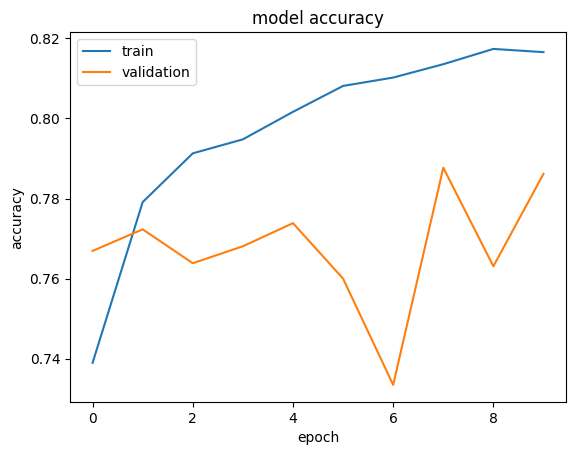

82/82 [==============================] - 37s 446ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1300
           1       0.80      0.76      0.78      1300

    accuracy                           0.79      2600
   macro avg       0.79      0.79      0.79      2600
weighted avg       0.79      0.79      0.79      2600



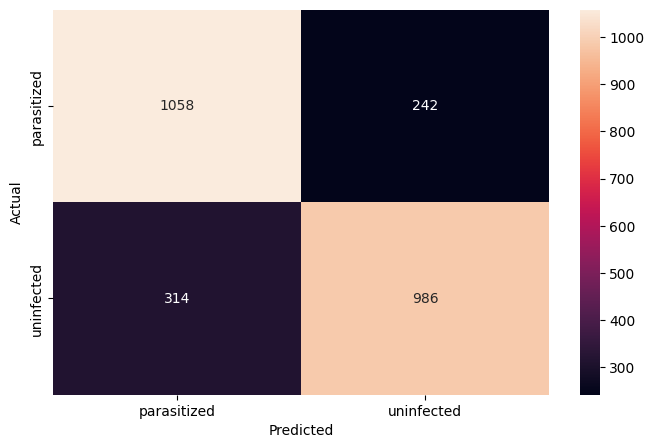

In [ ]:
# Print and save reports for each model here
accuracy_reports_dict["vgg16_augmented"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###<b>Think about it:</b>

**Observations and insights:**

* Transfer learning from VGG16 model does not give good performance for our dataset.
* Parasitzed recall has reduced to %83, and recall for uninfected class has also reduced to %75.
* 223 infected(parasitzed) patients were diagnosed as uninfected and 321 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients, which is huge inaccuracy.
* As previous model had far better performance we will select that as final model.


After milestone 1:

#**Attempt 6. cnn_model_1 with gaussian blurred augmented data**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

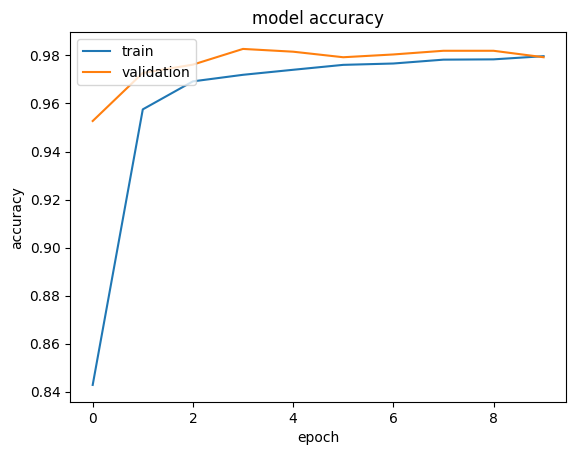

82/82 [==============================] - 4s 45ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



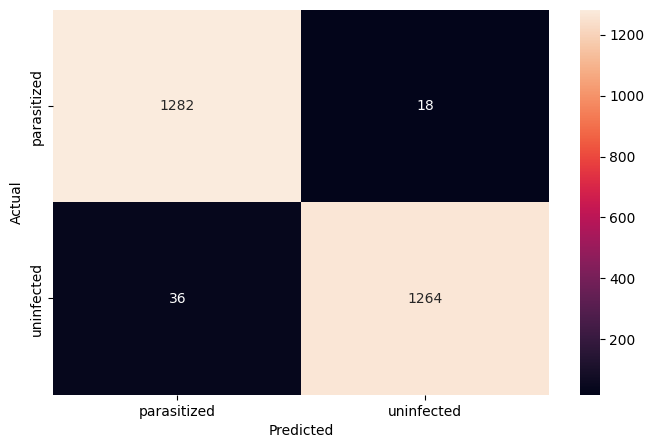

In [ ]:
# # choosing the final model
model = cnn_model_1()

#Please use augmented datset train_augmented
# Epochs
epochs = 10
history = model.fit(train_augmented,
                    epochs = epochs,
                    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                    validation_data = (X_test_normalized, y_test_encoded),
                    verbose = 1, callbacks = [learning_rate_reduction])

# Print and save reports for each model here
accuracy_reports_dict["cnn_model_1_augmented"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>

Observations and insights drawn from the final model:

* The performance of ths model is very good.
* Parasitzed recall has improved at 99%, but recall for uninfected class is slightly lower 97%.
* 18 infected(parasitzed) patients were diagnosed as uninfected and 36 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* This can be a strong candidate for final model.







#**Attempt 7. cnn_model_1 with bilateral blurred data**

* Using bilaterally blurred train images instead of gaussian blur.

Min  [0.0, 0.0, 0.0]
Max  [0.7019608, 1.0, 0.972549]
Min  [0.0, 0.0, 0.0]
Max  [0.7019608, 0.99607843, 0.9764706]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
        

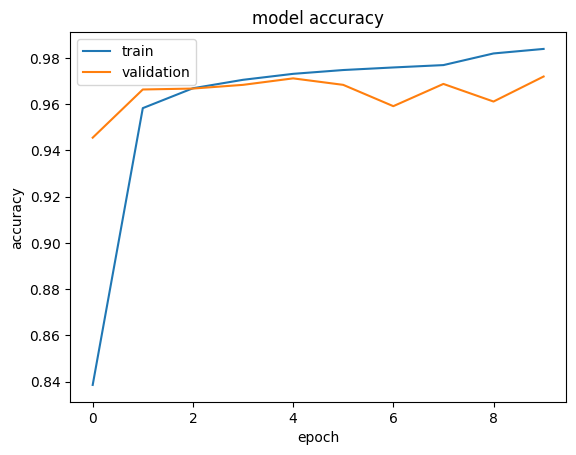

82/82 [==============================] - 4s 53ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1300
           1       0.98      0.97      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



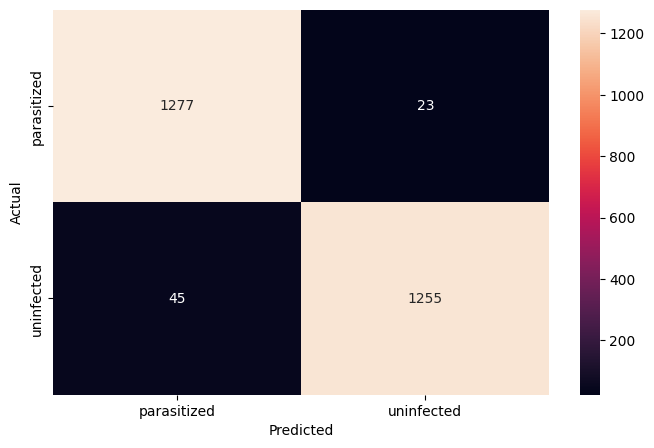

In [ ]:
# Trying Bilateral blurred images for training
X_train_normalized, X_test_normalized = get_normalized_features(X_train_hsv_bilateral, X_test_hsv_bilateral)

initialize_session()

# Train model
model, history = fit_model(cnn_model_1(), X_train_normalized, y_train_encoded)
accuracy_reports_dict["cnn_model_1_bilateral_blur"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>

Observations and insights drawn from the final model:

* The performance of ths model is good but we have seen better.
* Parasitzed recall at 98%, but recall for uninfected class is 97%.
* 23 infected(parasitzed) patients were diagnosed as uninfected and 45 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* As we have seen omdels with better parasitized recall and F1-score this model is not our top contender.







#**Attempt 8. cnn_model_2 with bilateral blurred and augmented data**

In [ ]:
# Batch size
batch_size = 64

train_augmented = datagen.flow(X_train_normalized, y_train_encoded,
                              batch_size = batch_size,
                              shuffle = False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

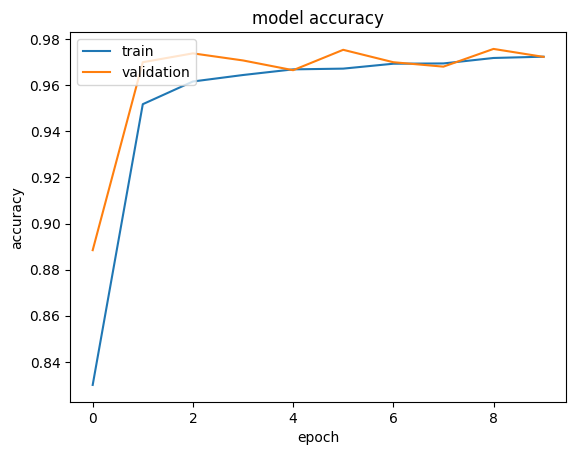

82/82 [==============================] - 6s 67ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1300
           1       0.95      0.99      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



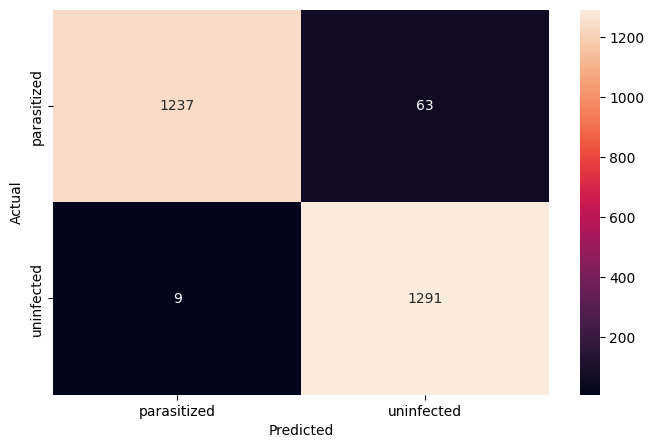

In [ ]:
initialize_session()
# Epochs
epochs = 10
model = cnn_model_2()

#Use the previous model to train with augmented data
history = model.fit(train_augmented,
                    epochs = epochs,
                    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                    validation_data = (X_test_normalized, y_test_encoded),
                    verbose = 1, callbacks = [learning_rate_reduction])

accuracy_reports_dict["cnn_model_2_bilateral_blur_augmented"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>

Observations and insights drawn from the final model:

* The performance of ths model is not the best
* Parasitzed recall has reduced to 95%, but recall for uninfected class is slightly slightly higher 99%.
* 63 infected(parasitzed) patients were diagnosed as uninfected and 9 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* As we have seen omdels with better parasitized recall and F1-score this model is not our top contender.







#**Attempt 9. cnn_model_1 with bilateral blurred and augmented data**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

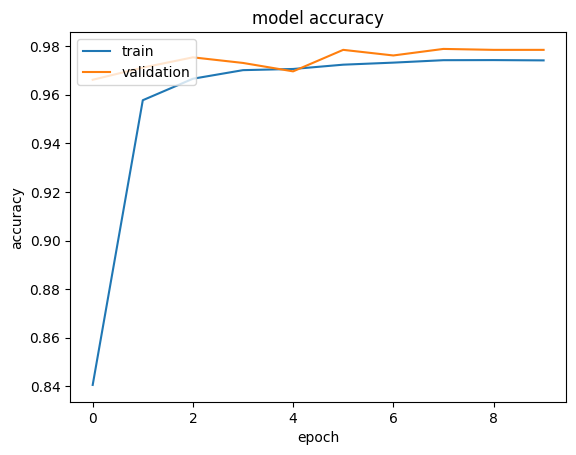

82/82 [==============================] - 4s 52ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



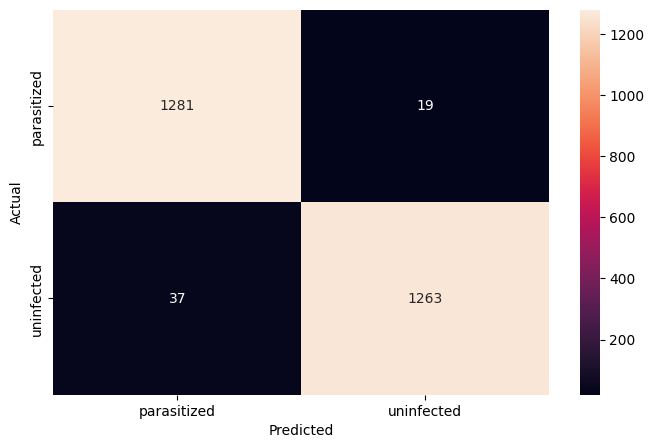

In [ ]:
initialize_session()

# Epochs
epochs = 10
model = cnn_model_1()

#Use the previous model to train with augmented data
history = model.fit(train_augmented,
                    epochs = epochs,
                    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                    validation_data = (X_test_normalized, y_test_encoded),
                    verbose = 1, callbacks = [learning_rate_reduction])

accuracy_reports_dict["cnn_model_1_bilateral_blur_augmented"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>

Observations and insights drawn from the final model:

* The performance of ths model is very good.
* Parasitzed recall has improved at 99%, but recall for uninfected class is slightly lower 97%.
* 19 infected(parasitzed) patients were diagnosed as uninfected and 37 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* This can be a strong candidate for final model.







#**Attempt 10. cnn_model_1 with HSV colorspace and augmented data**

* As Attempt 6 performed very good  trying that model again. Visualization of RBC images does not show any noise in them hence trying to train the model without any blurring. Using HSV colorspace images for training.  


Min  [0.0, 0.0, 0.0]
Max  [0.7019608, 1.0, 1.0]
Min  [0.0, 0.0, 0.0]
Max  [0.7019608, 1.0, 1.0]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                          

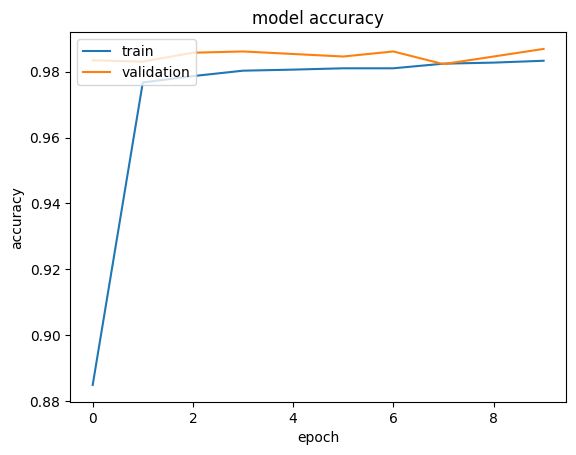

82/82 [==============================] - 4s 44ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



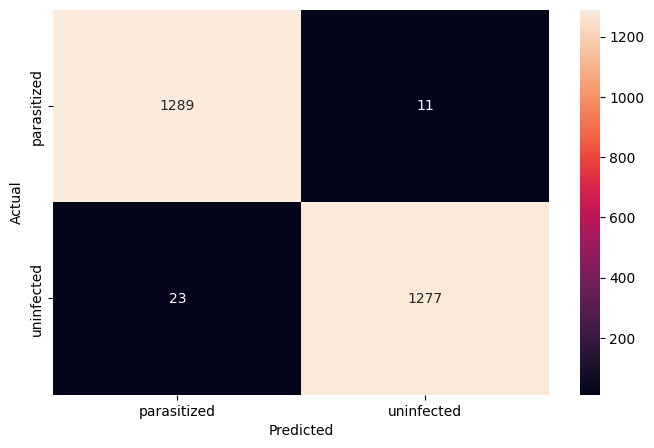

In [ ]:
# Trying hsv images without blurring for training
X_train_normalized, X_test_normalized = get_normalized_features(X_train_hsv, X_test_hsv)

initialize_session()

# Epochs
epochs = 10
model = cnn_model_1()
batch_size=64

# Get augmented images with 20 degree rotation
train_augmented = get_augmented_data(X_train_normalized, y_train_encoded, batch_size=batch_size)

#Use the previous model to train with augmented data
history = model.fit(train_augmented,
                    epochs = epochs,
                    steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                    validation_data = (X_test_normalized, y_test_encoded),
                    verbose = 1, callbacks = [learning_rate_reduction])

# Print and save reports for each model here
accuracy_reports_dict["cnn_model_1_hsv_augmented"] = evaluate_model(model, history, X_test_normalized, y_test_encoded)

###**Think About It :**<br>

Observations and insights drawn from the final model:

* The performance of ths model is better than all attempts before.
* Parasitzed recall is 99%, and recall for uninfected class is 98%.
* F1-score and average accuracy is 99%
* 11 infected(parasitzed) patients were diagnosed as uninfected and 23 uninfected patients were incorrectly diagnosed as infected out of a total of 2600 patients.
* This can be a strong candidate for final model.







# <b>Conclusions:

<b>Printing the classification reports for all the models for comparison.

In [ ]:
for model_name, report in accuracy_reports_dict.items():
  print(model_name)
  print(report)



cnn_model_0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1300
           1       0.00      0.00      0.00      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600

cnn_model_1
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600

cnn_model_2
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98     

In [ ]:
#Here's the classification report for Attempt 10
print('cnn_model_1_hsv_augmented')
print(accuracy_reports_dict['cnn_model_1_hsv_augmented'])

cnn_model_1_hsv_augmented
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



#### **Insights**

####**Refined insights**:
* Shape of the RBC cell is not a clear indicator of presence of infection.
* Healthy RBC cells come in various shades of blue, purple and pink.
* The real differentiator is the presence of darker color pigmentation in the cell.
* Parasitized RBC cells images have clear darker color pigmentation detectable by human eye.
* Need to discuss with business regarding the level of accuracy expected from Deep learning Model. We should also look at the accuracy of human diagnosis methods can achieve.




####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
* **Attempt 1. cnn_model_0 with gaussian blurred data:** used CNN with 2 hidden layers and Relu activation. This resulted in an underfit model. The F1-score was at (parasitized - 0.75, uninfected - 0.52)
* **Attempt 2. cnn_model_1 with gaussian blurred data:** used CNN with 4 hidden layers and Relu activation. This improved the performance significantly.  The F1-score was at (parasitized - 0.98, uninfected - 0.98). So far this is the top model.  

* **Attempt 3. cnn_model_2 with gaussian blurred data:** As previous model performed pretty decent we decided to start with the same number of hidden layers and added LeakyRelu as the activation method. Then we added batch normalization step after every other hidden layer. This helped in  making neural networks faster and more stable through adding extra layers in a deep neural network. The F1-score was at (parasitized - 0.97, uninfected - 0.97)
Only issue was we noticed was a little dip in model accuracy while testing with test data, hence we continued to explore further options.

* **Attempt 4. cnn_model_2 with gaussian blurred data and data Augmentation:** Previous CNN model 2 with significant deep learning layers, Batch normalization at interim stages and LeakyReLU activation seems to work great with Augmented data. As image means shows that cells are pretty circular in shape we are applying on 20 Degree range for random rotations while augmenting the data. This seem to result in very good stable performance. The F1-score was at (parasitized - 0.98, uninfected - 0.98).

* **Attempt 5. Pre-trained model (VGG16) with augmented data:** This model was not able to get good performance in detecting the infection. It resulted in very poor performance.

* **Attempt 6. cnn_model_1 with gaussian blurred augmented data:**
  * As 'Attempt 2 with cnn_model_1' performed better than 'Attempt 3 with cnn_model_2'. Probably means LeakyRelu activation did not help much. So trying data augmentation(20 Degree range for random rotations) with cnn_model_1.
  * We clearly see improved performance, comparable to top model so far.

* **Attempt 7. cnn_model_1 with bilateral blurred data:** We tried Bilateral blur as pre-processing instead of Gaussian to see if performance can be improved with cnn_model_1. But we did not see significant improvement.

* **Attempt 8. cnn_model_2 with bilateral blurred and augmented data:** Also tried Bilateral blur with cnn_model_2 and augmented data and performace was not able to beat the top models.

* **Attempt 9. cnn_model_1 with bilateral blurred and augmented data:** As Attempt 6 was one of the top contenders, trying similar approach with bilateral blur as pre-processing step. And see very comparable performace.

* **Attempt 10. cnn_model_1 with HSV colorspace and augmented data** As Attempt 6 performed very good  trying that model again. visualization of RBC images does not show any noise in them hence trying to train the model without any blurring. Using HSV colorspace images for training.  




####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

* F1-score for following models is highest at 98% or mode.
cnn_model_1 and cnn_model_2_augmented is the highest at 98%. So we could pick one of these models as our final model.
  * cnn_model_1 (gaussian blur)
  * cnn_model_2 (gaussian blur)
  * cnn_model_2_augmented (gaussian blur)
  * cnn_model_1_augmented (gaussian blur)
  * cnn_model_1_bilateral_blur_augmented
  * cnn_model_1_hsv_augmented

* Given the severity of this disease, the business requirement is to avoid as many false negatives as possible for parasitzed(infected) patients. So we need to compare recall scores and pick the model with highest recall score for parasitized.

* If we compare just the recall scores for these  models cnn_model_1, cnn_model_1_augmented, cnn_model_1_bilateral_blur_augmented, cnn_model_1_hsv_augmented have better recall value for parasitized class. Which means there are very few false negatives diagnosing infected patients as uninfected. So we could pick any of these models.

* Clearly these 4 models have the same underlying model(cnn_model_1) but the data used to train the model has different pre-processing applied.

* As recall value for parasitized class is same for these models, we looked at the actual number of false negatives and false positives, it looks like cnn_model_1_hsv_augmented performed the best in all aspects with F1-score and average accuracy of 99%.

* We would like to pick **Attempt 10. cnn_model_1 with HSV colorspace augmented data** as our final model.  



**Improvements that can be done:**<br>


Can the model performance be improved using other pre-trained models or different CNN architecture?
* If we are looking to further improve the performance we can try other **ResNet50 and EfficientNet** transfer learning models.
* Used picture_size of 32 in all models to speed up the model building process. Image size of **64x64** was taking 10 mins per epoch while buildign the model.But we can consider using larger picture size of 64 and see if we can improve accuracy further.
* Also, we can try playing around with **higher degree of rotation** for data augmentation on training data to see if we can improve performance.
* We can try **re-building** other models with **HSV** images




#**Executive Summary**
**What are the most important findings from the analysis done in Milestone? Describe the final proposed model specifications?**

This project proposes a Deep Learning technique using a lighweight **Convolutional neural network model** for detection of Malaria. It uses microscopic images of RBC blood cells to learn from training data to define infection. This Model shows high conformance to observed training data and near perfect **accuracy of 99%**. Proposed model is lighweight with low computational requirements and hence can be deployed easily in medical setting with very low recurring cost.

While we have taken every effort to reduce overfitting of the model to training data, the performance is only tested with provided test data. Depending on the severity of endemic in an area the immunity of humans and other regional or genetic factors can influence how parasites impact the RBC cells. Stakeholders must consider testing this model with data from different regions. Depending on the findings we might have to consider training our model using representations from diverse datasets.   


#**Problem and solution summary**
Provide the summary of the problem?  State the reasons for the proposed solution design? How it would affect the problem/business?

* Malaria is still an endemic in many parts of the world and it is especially dangerous in vulnerable populations. Even though it is fully treatable, delay in diagnosis can be fatal or cause severe long term side effects.

* As traditional diagnosis of malaria in the laboratory is tedious and resource intensive, we ventured on trying to develop an automated system to help with the early and accurate detection of malaria using AI/ML techniques.

* After extensive analysis we found that a Deep learning model using Convolusional neural networks works the best with images converted to HSV colorspace. Specifics of the architecture is explained in **Recommendations for implementation** section.
* Overall we are able to get 99% of accuracy in detecting RCB cells that are infected with Malaria parasites. And the model performs especially better in minimizing False negatives which is crutial given the severity of the disease.



#**Recommendations for implementation**



###**Key recommendations for implementation:**

####**Model architecture:**

**Attempt 10. cnn_model_1 with HSV colorspace and augmented data**

* Convolusion neural network with 4 hidden layers
  * Layer 1 - 128 neurons
  * Layer 2 - 64 neurons
  * Layer 3 - 64 neurons
  * Layer 4 - 32 neurons
* **Maxpooling** applied after every other hidden layer for dimensionality reduction
* Fully connected **dense** hidden layer with 64 neurons after flattening the image vectors
* Using **Relu activation** after each layer
* Final output layer with single neuron, **binary_crossentropy** and **sigmoid activation**.
* **Dropout** layer added finally to drop **30%** of neurons to reduce overfitting to training data.

**Training data pre-processing:**
  * Images converted to **HSV** colorspace
  * no blurring technique used
  * Added **augmented images** for training with 20 degrees of rotation.

This is a lighweight model with a total of 141,089 Trainable params and 0 Non-trainable params.


###**Stakeholders:**





####**Key actionables:**

* Get access to a test playground to futher validate and improve the model.
* Obtain accuracy and consistency reports from traditional lab based Malaria detection methods for comparison and risk anaysis.
* Review images that ended up as false negatives and get skilled pathologists perspective on that. Explore if other risk factors can be included in further diagnosing the patient.

####**Benefits, Costs, Rational assumptions:**

- What is the expected benefit and/or costs (List the benefits of the solution. What are the Rational assumptions to put forward some numbers on costs/benefits for stakeholders)?

This approach has many advantages,
1. Consistent and predictable accuracy as compared to manual pathological methods which depends on human expertize and can be inconsistent.

2. Learnings from the data from different malaria-endemic areas can be used to train the models and improve overall acuuracy even further.

3. Proposed model is lighweight with low computational requirements and hence can be deployed easily in medical setting.

4. According to [Bio Med Central - Infectious Diseases of Poverty](https://rdcu.be/demd7), the average cost of diagnosis by RDT was USD 2.19 per test, and diagnosis by microscopy was USD 6.98 per test.

5. After the initial cost of creating, deploying and maintaning the model the recurring costs are very minimal compared to traditional diagnostic methods as mentioned above.

####**Risks or challenges of the proposed solution design:**

 1. The performance of the model is only validated with provided test data, hence it might lack the ability to detect malaria for under represented populations. For example, depending on the severity of endemic in an area the immunity of humans and other regional or genetic factors can influence how parasites attack the RBC cells.

 2. As the model is seeing an error rate of 1% there might be few cases of False negatives and False positives. Medical intervention and further PCR tests will have to be ordered in high risk patients.

####**Further analysis:**
What further analysis needs to be done or what other associated problems need to be solved?

1. Stakeholders must consider testing this model with data from different regions. Depending on the findings we might have to consider training our model using representations from diverse datasets.

2. Other model improvements can be tried as described in **Proposal for final design** section above.

3. **Review** images that ended up as **false negatives** and get skilled pathologists perspective to het any hints for further improving the model.


#**References:**

* [Center for Disease Control and Prevention](https://www.cdc.gov/parasites/malaria/index.html)
* [World Health Organization](https://www.who.int/teams/global-malaria-programme)
* [Bio Med Central - Malaria Journal](https://rdcu.be/demdN)
* [Bio Med Central - Infectious Diseases of Poverty](https://rdcu.be/demd7)